#### 1) Imports and Random Seed

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import sys
import random; import numpy as np; import torch


SEED = 78
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [30]:
!pip install pot


In [31]:
os.chdir("/kaggle/input")
os.listdir()


['realness-dataset', 'joint_checkpoint', 'raise-final-dataset-paper', 'joint']

In [ ]:
# Make sure to put https://github.com/zijianchen98/AGIN/blob/main/JOINT/models/JOINT.py in the same directory as this notebook


In [32]:
sys.path.insert(1, '/kaggle/input/joint/pytorch/default/1/')
import JOINT


#### 2) Dataset and Dataloader

In [35]:
class ImageRatingDataset(Dataset):
    
    def __init__(self, dataframe, transform=None, augment=False, phase=''):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])
        self.augment = augment
        self.phase=phase

        # Define augmentations
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # small rotations
            transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
        ])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        rating = self.dataframe.loc[idx, 'MOS']
        
        if self.phase == 'train':
            image = Image.open("/kaggle/input/raise-final-dataset-paper/dataset/images/train_images/" + img_path).convert('RGB')
        elif self.phase == 'test':
            image = Image.open("/kaggle/input/raise-final-dataset-paper/dataset/images/test_images/" + img_path).convert('RGB')

        if self.augment == True:
            image = self.augmentation(image)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


#### 3) Create Model

In [36]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        self.model = JOINT.JOINT_Model()
        self.model.load_state_dict(torch.load('/kaggle/input/joint_checkpoint/pytorch/default/1/JOINT_2024.pth'))
      

        # # Remove the final classification layer
        # self.features = nn.Sequential(*list(base_model.children())[:-1])  # Excludes fc layer

        self.features = nn.Sequential(*list(self.model.rationality_feature_extraction.children()))[:-1]

        # # Freeze base layers
        # for param in self.features.parameters():
        #     param.requires_grad = False

        # for param in self.features.parameters():
        #     param.requires_grad = False

        for layer in self.features[:-2]:
            for param in layer.parameters():
                param.requires_grad = False
            layer.eval()  
        
        # Unfreeze last 2 blocks (keep in train mode)
        for param in self.features[-2:].parameters():
            param.requires_grad = True

     
        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)  # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 512)
        x = self.regressor(x)
        x = x.view(x.size(0), -1)
        return x


#### 4) Training of model

In [43]:
def train_model(model, train_loader, val_loader, num_epochs, lr=0.0001, λ=1):
    # Set up optimizer and losses

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=0)
    
    mse_loss = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    srocc_scores = []
    
    # Track best model
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    
    model.to(device)
    for epoch in range(num_epochs):
        # --- Training phase ---
        model.train()
        running_loss = 0.0
        for images, ratings in train_loader:
            images, ratings = images.to(device), ratings.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            
            loss = mse_loss(outputs, ratings)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # --- Validation phase ---
        val_loss, srocc = validate_model(model, val_loader, device=device)
        val_losses.append(val_loss)
        srocc_scores.append(srocc)
        
        print(f"Epoch {epoch+1}/{num_epochs} — "
              f"Train: {avg_train_loss:.4f}  Val: {val_loss:.4f}  SROCC: {srocc:.4f}")
        
        # --- Check for new best ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # --- Load best weights back into model ---
    model.load_state_dict(best_model_wts)
    print(f"Loaded best model weights with val_loss={best_val_loss:.4f}")
    
    # --- Plot curves ---
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs+1), val_losses,   label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    # plt.savefig("loss_curve.png")
    plt.show()
    
    return model, train_losses, val_losses, srocc_scores 


In [44]:
def validate_model(model, val_loader, device):
    model.eval()
    val_predictions = []
    val_ground_truth = []
    # srocc_loss = ApproximateSROCCLoss()
    
    with torch.no_grad():
        for images, ratings in val_loader:
            images = images.to(device)
            ratings = ratings.to(device)

            outputs = model(images).squeeze(1)  # Remove extra dimension

            val_predictions.extend(outputs.cpu().numpy())
            val_ground_truth.extend(ratings.cpu().numpy())

    # Compute SROCC
    srocc, _ = spearmanr(val_predictions, val_ground_truth)

    # Compute mean squared error for validation loss
    val_loss = mean_squared_error(val_ground_truth, val_predictions) 

    return val_loss, srocc


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetRegressor().to(device)


/tmp/ipykernel_31/3989269857.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('/kaggle/input/joint_checkpoint/pytorch/default/1/JOIN

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 47,547,237


#### 5) Load CSV and stratified split data, training loop

In [ ]:
# train_df = pd.read_csv("/kaggle/input/raise-final-dataset-paper/dataset/ratings/train.csv")
# test_df = pd.read_csv("/kaggle/input/raise-final-dataset-paper/dataset/ratings/test.csv")

train_df = pd.read_csv("../../dataset/ratings/train.csv")
test_df = pd.read_csv("../../dataset/ratings/test.csv")

val_df = train_df.iloc[-90:].copy()
train_df = train_df.iloc[:-90].copy()

print(train_df.shape, val_df.shape, test_df.shape)


(420, 2) (90, 2) (90, 2)


Epoch 1/75 — Train: 0.9931  Val: 0.9776  SROCC: 0.5817
Epoch 2/75 — Train: 0.9498  Val: 0.8419  SROCC: 0.6550
Epoch 3/75 — Train: 0.7483  Val: 0.5701  SROCC: 0.6190
Epoch 4/75 — Train: 0.5258  Val: 0.4781  SROCC: 0.6562
Epoch 5/75 — Train: 0.3676  Val: 0.4695  SROCC: 0.6929
Epoch 6/75 — Train: 0.4436  Val: 0.4325  SROCC: 0.6731
Epoch 7/75 — Train: 0.3067  Val: 0.4702  SROCC: 0.6745
Epoch 8/75 — Train: 0.2615  Val: 0.4654  SROCC: 0.6286
Epoch 9/75 — Train: 0.2207  Val: 0.4493  SROCC: 0.6464
Epoch 10/75 — Train: 0.1801  Val: 0.4384  SROCC: 0.6801
Epoch 11/75 — Train: 0.1885  Val: 0.4459  SROCC: 0.6475
Epoch 12/75 — Train: 0.1872  Val: 0.5440  SROCC: 0.6105
Epoch 13/75 — Train: 0.1783  Val: 0.4478  SROCC: 0.6499
Epoch 14/75 — Train: 0.1629  Val: 0.5087  SROCC: 0.6544
Epoch 15/75 — Train: 0.1866  Val: 0.5163  SROCC: 0.6264
Epoch 16/75 — Train: 0.1991  Val: 0.5185  SROCC: 0.6225
Epoch 17/75 — Train: 0.2165  Val: 0.4826  SROCC: 0.6573
Epoch 18/75 — Train: 0.1837  Val: 0.4199  SROCC: 0.7033
E

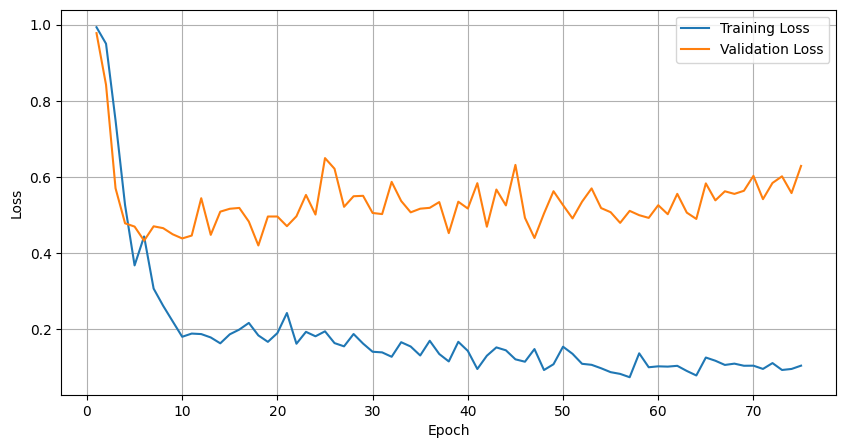

In [48]:
# Create dataset partitions
train_dataset = ImageRatingDataset(train_df, augment=True, phase='train')
val_dataset = ImageRatingDataset(val_df, phase='train')
test_dataset = ImageRatingDataset(test_df, phase='test')


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


# Start training
model, train_losses, val_losses, srocc_scores = train_model(
    model, train_loader, val_loader, num_epochs=75
)


#### 6) Model Evaluation

In [49]:
model.eval()

# model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(spearman_corr, pearson_corr)


0.7033378606412314 0.7626243


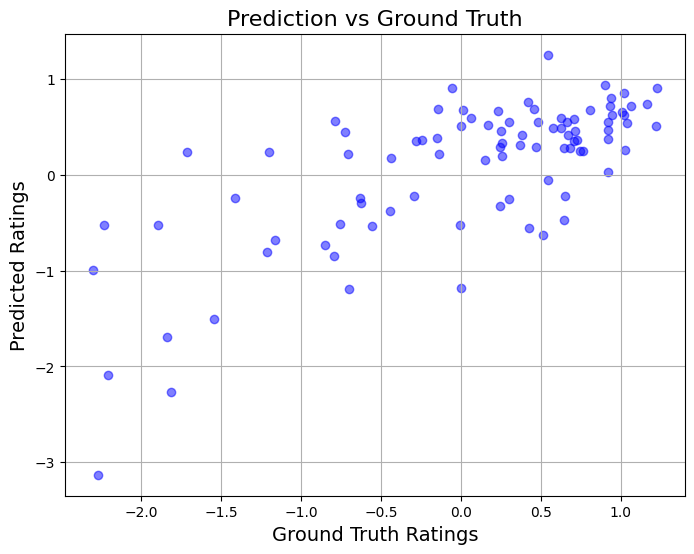

0.6386714409186319 0.72399336


In [51]:
predictions = []
ground_truths = []

# Iterate over the validation dataset

with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device)  # Move to device (GPU or CPU)
        ratings = ratings.to(device)

        # Get predictions from the model
        predicted_ratings = model(images)

        # Append predicted and ground truth values to the lists
        predictions.extend(predicted_ratings.cpu().numpy())  # move to CPU and convert to numpy
        ground_truths.extend(ratings.cpu().numpy())  # move to CPU and convert to numpy

# Convert lists to numpy arrays
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()

# # # denormalize
# predictions = predictions*mos_std + mos_mean
# ground_truths = ground_truths*mos_std + mos_mean 

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)


In [ ]:
import torch, os

#TODO: Change this directory path based on where you want to save the weights.

SAVE_DIR = "/kaggle/working"            # this is the only writable spot
WEIGHT_FILE = "resnet50_joint-weights.pth"

os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(model.state_dict(), f"{SAVE_DIR}/{WEIGHT_FILE}")
print("✔️  Weights written to", f"{SAVE_DIR}/{WEIGHT_FILE}")


✔️  Weights written to /kaggle/working/resnet50_joint-weights.pth
